In [7]:
import os
import tensorflow as tf
from keras import Sequential
from keras import layers as KLayers
from keras import losses
from keras._tf_keras.keras.optimizers import Adam

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
data_dir = 'faces_data'

In [35]:
def inspect_dataset(ds):
    for images, labels in ds.take(5):  # Inspect the first 5 batches
        print("Image shape:", images.shape)
        print("Label shape:", labels.shape)

In [2]:
def preprocess_image(image, label):
    # Resize the image to 256x256
    image = tf.image.resize(image, [256, 256])
    return image, label

In [3]:
def check_shapes(dataset):
    for image, label in dataset.take(5):  # Check the first 5 images
        print("Image shape:", image.shape)
        print("Label shape:", label.shape)


In [8]:
def prepare_dataset(ds, batch_size, shuffle_buffer=1000, shuffle=True):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    ds = ds.flat_map(lambda x, y: tf.data.Dataset.from_tensor_slices((x, y)))
    ds = ds.padded_batch(batch_size, padded_shapes=([256,256,3],[3]),drop_remainder=False)
    return ds.prefetch(tf.data.AUTOTUNE)

In [16]:
def create_model(input_shape):
        
    model = Sequential()

    model.add(KLayers.Input(shape=input_shape))

    model.add(KLayers.Conv2D(16,(3,3),1,activation='relu'))
    model.add(KLayers.MaxPooling2D())

    model.add(KLayers.Conv2D(32,(3,3),1,activation='relu'))
    model.add(KLayers.MaxPooling2D())

    model.add(KLayers.Conv2D(16,(3,3),1,activation='relu'))
    model.add(KLayers.MaxPooling2D())

    model.add(KLayers.Flatten())

    model.add(KLayers.Dense(256,activation='relu'))
    model.add(KLayers.Dense(3,activation='softmax'))

    return model

In [11]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),
    label_mode='categorical'  # Ensure labels are one-hot encoded
)

Found 620 files belonging to 3 classes.


In [12]:

DATASET_SIZE = tf.data.experimental.cardinality(dataset).numpy()

# Define the sizes of your splits
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

dataset = dataset.shuffle(DATASET_SIZE, reshuffle_each_iteration=False)

# Split the dataset
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [13]:
# Get input shape from the dataset
for images, _ in train_dataset.take(1):
    input_shape = images.shape[1:]


2024-10-10 19:46:58.931624: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
batch_sizes = [16, 32, 64]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
results = []
with tf.device('/GPU:0'):
    for batch_size in batch_sizes:
        for lr in learning_rates:
            print(f"Training with batch size: {batch_size}, learning rate: {lr}\n")
            train_dataset_batched = dataset.batch(batch_size)
            model = create_model(input_shape)
            model.compile(optimizer=Adam(learning_rate=lr),loss=losses.categorical_crossentropy,metrics=['accuracy'])
            
            history = model.fit(train_dataset,
                                epochs=30,
                                validation_data=val_dataset,
                                verbose=1)
            
            # Evaluate on validation set
            val_loss, val_accuracy = model.evaluate(val_dataset, verbose=1)
            
            results.append({
                'batch_size': batch_size,
                'learning_rate': lr,
                'val_accuracy': val_accuracy,
                'val_loss': val_loss
            })
            
            print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")

In [22]:
# Find best parameters
best_result = max(results, key=lambda x: x['val_accuracy'])
print("\nBest parameters:")
print(f"Batch Size: {best_result['batch_size']}")
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Validation Accuracy: {best_result['val_accuracy']:.4f}")


Best parameters:
Batch Size: 16
Learning Rate: 0.0001
Validation Accuracy: 0.9844


HERE BEST PARAMS ARE :
Best parameters: Batch Size: 16 
Learning Rate: 0.0001 
Validation Accuracy: 0.9844

In [58]:
# Prepare your datasets with the best batch size found
best_batch_size = best_result['batch_size']  # This comes from your hyperparameter tuning


In [17]:
# Train final model with best parameters
tf.keras.backend.clear_session()

final_model = create_model(input_shape)
final_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss=losses.categorical_crossentropy,
                    metrics=['accuracy'])

In [ ]:
for images, labels in train_dataset.take(1):
    print("Initial Image batch shape:", images.shape)
    print("Initial Label batch shape:", labels.shape)
final_train_batches = prepare_dataset(train_dataset, best_batch_size)
# Check the shapes of the output batches
for images, labels in final_train_batches.take(1):
    print("Image batch shape:", images.shape)  # Should be (batch_size, 256, 256, 3)
    print("Label batch shape:", labels.shape)   # Should be (batch_size, 3)

In [ ]:
final_train_batches = prepare_dataset(train_dataset, 16)
final_val_batches = prepare_dataset(val_dataset, 16, shuffle=False)

final_history = final_model.fit(final_train_batches,
                                epochs=100,  # You might want to increase epochs for final training
                                validation_data=final_val_batches,
                                callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)])


In [15]:
train_loss = final_history.history['loss']
val_loss = final_history.history['val_loss']
train_acc = final_history.history['accuracy']
val_acc = final_history.history['val_accuracy']

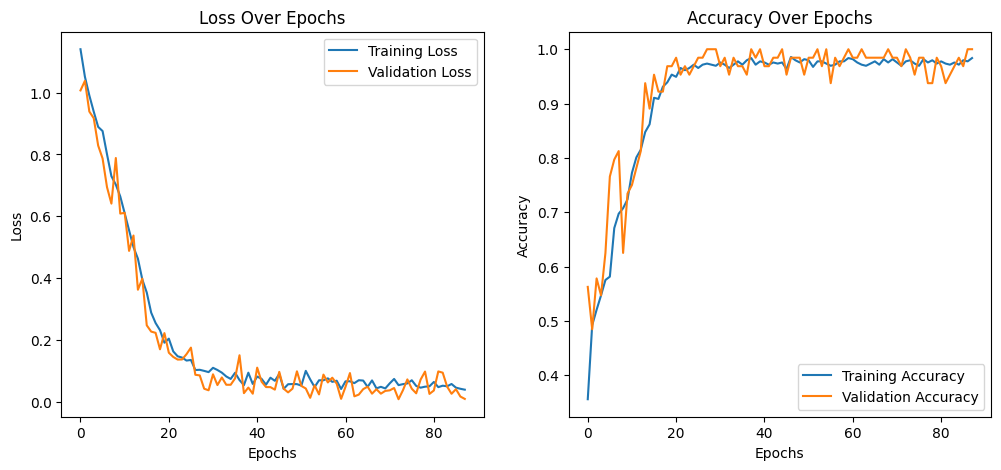

In [16]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.show()

In [19]:
# Evaluate on test set
final_test_batches = prepare_dataset(test_dataset, 16, shuffle=False)
test_loss, test_accuracy = final_model.evaluate(final_test_batches)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f},Final Test Loss: {test_loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.2729 - loss: 1.1742

Final Test Accuracy: 0.2500,Final Test Loss: 1.1899


2024-10-10 19:48:50.038245: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 19:48:50.038315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16176131471929611981
2024-10-10 19:48:50.038351: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11582738936467888200


In [22]:
final_model.save(os.path.join('models','emotions_model.keras'))